In [2]:
from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, UpSampling2D
from keras import backend as K

import random
import glob
import wandb
from wandb.keras import WandbCallback
import subprocess
import os
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow, figure


In [3]:
#initialize wandb and download dataset

hyperparams = {"num_epochs": 10, 
          "batch_size": 32,
          "height": 96,
          "width": 96}

wandb.init(config=hyperparams)
config = wandb.config

val_dir = 'catz/test'
train_dir = 'catz/train'

# automatically get the data if it doesn't exist
if not os.path.exists("catz"):
    print("Downloading catz dataset...")
    subprocess.check_output(
        "curl https://storage.googleapis.com/wandb/catz.tar.gz | tar xz", shell=True)

W&B Run: https://app.wandb.ai/l2k2/ml-class-examples_keras-video-predict/runs/cje1n44s
Call `%%wandb` in the cell containing your training loop to display live results.


In [4]:
# generator to loop over train and test images

def my_generator(batch_size, img_dir):
    """A generator that returns 5 images plus a result image"""
    cat_dirs = glob.glob(img_dir + "/*")
    counter = 0
    while True:
        input_images = np.zeros(
            (batch_size, config.width, config.height, 3 * 5))
        output_images = np.zeros((batch_size, config.width, config.height, 3))
        random.shuffle(cat_dirs)
        if (counter+batch_size >= len(cat_dirs)):
            counter = 0
        for i in range(batch_size):
            input_imgs = glob.glob(cat_dirs[counter + i] + "/cat_[0-5]*")
            imgs = [Image.open(img) for img in sorted(input_imgs)]
            input_images[i] = np.concatenate(imgs, axis=2)
            output_images[i] = np.array(Image.open(
                cat_dirs[counter + i] + "/cat_result.jpg"))
            input_images[i] /= 255.
            output_images[i] /= 255.
        yield (input_images, output_images)
        counter += batch_size
        
steps_per_epoch = len(glob.glob(train_dir + "/*")) // config.batch_size
validation_steps = len(glob.glob(val_dir + "/*")) // config.batch_size

In [5]:
#callback to log the images

class ImageCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        validation_X, validation_y = next(
            my_generator(15, val_dir))
        output = self.model.predict(validation_X)
        wandb.log({
            "input": [wandb.Image(np.concatenate(np.split(c, 5, axis=2), axis=1)) for c in validation_X],
            "output": [wandb.Image(np.concatenate([validation_y[i], o], axis=1)) for i, o in enumerate(output)]
        }, commit=False)

In [83]:
# Test the generator
gen = my_generator(2, train_dir)
videos, next_frame = next(gen)
videos[0].shape
next_frame[0].shape

(96, 96, 3)

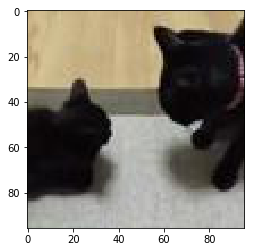

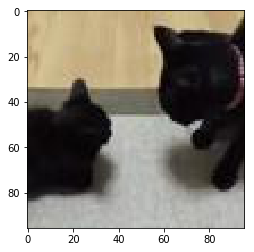

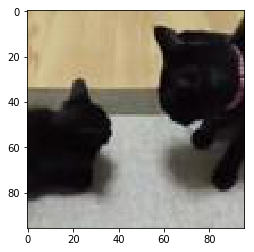

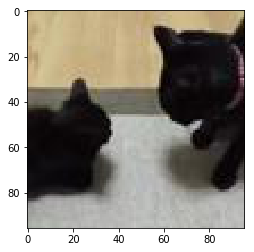

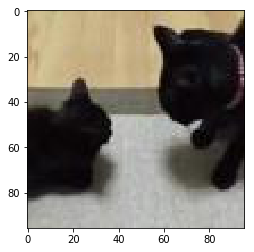

In [64]:
figure()
imshow(videos[0][:,:,0:3])
figure()
imshow(videos[0][:,:,3:6])
figure()
imshow(videos[0][:,:,6:9])
figure()
imshow(videos[0][:,:,9:12])

figure()
imshow(next_frame[0][:,:,0:3])

In [7]:
# Function for measuring how similar two images are
def perceptual_distance(y_true, y_pred):
    y_true *= 255.
    y_pred *= 255.
    rmean = (y_true[:, :, :, 0] + y_pred[:, :, :, 0]) / 2
    r = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    g = y_true[:, :, :, 1] - y_pred[:, :, :, 1]
    b = y_true[:, :, :, 2] - y_pred[:, :, :, 2]

    return K.mean(K.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)))

In [84]:
wandb.init(config=hyperparams)
config = wandb.config

model = Sequential()
model.add(Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(config.height, config.width, 5 * 3)))

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))



W&B Run: https://app.wandb.ai/l2k2/ml-class-examples_keras-video-predict/runs/ne93ynbj
Call `%%wandb` in the cell containing your training loop to display live results.
Epoch 1/10
52/52 [==============================] - 10s 186ms/step - loss: 0.0491 - perceptual_distance: 138.4108 - val_loss: 0.0190 - val_perceptual_distance: 76.8124
Epoch 2/10
52/52 [==============================] - 9s 170ms/step - loss: 0.0157 - perceptual_distance: 66.7613 - val_loss: 0.0138 - val_perceptual_distance: 60.2717
Epoch 3/10
52/52 [==============================] - 10s 186ms/step - loss: 0.0138 - perceptual_distance: 58.4320 - val_loss: 0.0125 - val_perceptual_distance: 56.8256
Epoch 4/10
52/52 [==============================] - 10s 189ms/step - loss: 0.0120 - perceptual_distance: 53.2015 - val_loss: 0.0103 - val_perceptual_distance: 48.9738
Epoch 5/10
52/52 [==============================] - 10s 192ms/step - loss: 0.0099 - perceptual_distance: 47.9817 - val_loss: 0.0086 - val_perceptual_distance: 44.2

In [85]:
# Baseline model - just return the last layer

from keras.layers import Lambda, Reshape, Permute

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

model=Sequential()
model.add(Reshape((96,96,5,3), input_shape=(config.height, config.width, 5 * 3)))
model.add(Permute((1,2,4,3)))
model.add(Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3)))

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

W&B Run: https://app.wandb.ai/l2k2/ml-class-examples_keras-video-predict/runs/2s4jh01s
Call `%%wandb` in the cell containing your training loop to display live results.
Epoch 1/10
52/52 [==============================] - 11s 205ms/step - loss: 0.0056 - perceptual_distance: 20.8150 - val_loss: 0.0040 - val_perceptual_distance: 17.8912
Epoch 2/10
52/52 [==============================] - 9s 169ms/step - loss: 0.0051 - perceptual_distance: 20.0967 - val_loss: 0.0058 - val_perceptual_distance: 21.1593
Epoch 3/10
52/52 [==============================] - 10s 195ms/step - loss: 0.0055 - perceptual_distance: 20.2913 - val_loss: 0.0044 - val_perceptual_distance: 18.0047
Epoch 4/10
52/52 [==============================] - 10s 191ms/step - loss: 0.0062 - perceptual_distance: 21.6678 - val_loss: 0.0056 - val_perceptual_distance: 20.6382
Epoch 5/10
52/52 [==============================] - 10s 197ms/step - loss: 0.0053 - perceptual_distance: 19.8640 - val_loss: 0.0046 - val_perceptual_distance: 18.37

KeyboardInterrupt: 

In [86]:
# Just return the last layer, functional style

from keras.layers import Lambda, Reshape, Permute, Input
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(permuted)
model=Model(inputs=[inp], outputs=[last_layer])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

W&B Run: https://app.wandb.ai/l2k2/ml-class-examples_keras-video-predict/runs/sgrxxlo6
Call `%%wandb` in the cell containing your training loop to display live results.
Epoch 1/10
52/52 [==============================] - 10s 198ms/step - loss: 0.0055 - perceptual_distance: 20.1021 - val_loss: 0.0049 - val_perceptual_distance: 19.9001
Epoch 2/10
35/52 [===================>..........] - ETA: 2s - loss: 0.0057 - perceptual_distance: 21.3775

KeyboardInterrupt: 

In [90]:
# Conv3D

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

hyperparams["num_epochs"] = 100
wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(permuted)
conv_output = Conv3D(1, (3,3,3), padding="same")(permuted)
conv_output_reshape = Reshape((96,96,3))(conv_output)
combined = add([last_layer, conv_output_reshape])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

W&B Run: https://app.wandb.ai/l2k2/ml-class-examples_keras-video-predict/runs/izmh58q9
Call `%%wandb` in the cell containing your training loop to display live results.
Epoch 1/100
52/52 [==============================] - 11s 221ms/step - loss: 0.0308 - perceptual_distance: 98.7534 - val_loss: 0.0142 - val_perceptual_distance: 57.7521
Epoch 2/100
52/52 [==============================] - 10s 187ms/step - loss: 0.0113 - perceptual_distance: 49.3992 - val_loss: 0.0107 - val_perceptual_distance: 46.4511
Epoch 3/100
52/52 [==============================] - 11s 207ms/step - loss: 0.0097 - perceptual_distance: 44.2018 - val_loss: 0.0082 - val_perceptual_distance: 41.2620
Epoch 4/100
52/52 [==============================] - 11s 210ms/step - loss: 0.0090 - perceptual_distance: 41.0019 - val_loss: 0.0066 - val_perceptual_distance: 35.8011
Epoch 5/100
52/52 [==============================] - 11s 208ms/step - loss: 0.0080 - perceptual_distance: 38.0702 - val_loss: 0.0077 - val_perceptual_distance:

KeyboardInterrupt: 

In [ ]:
# Conv3D with Gaussian Noise

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init()

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
conv_output = Conv3D(1, (3,3,3), padding="same")(noise)
conv_output_reshape = Reshape((96,96,3))(conv_output)
combined = add([last_layer, conv_output_reshape])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

W&B Run: https://app.wandb.ai/l2k2/ml-class-examples_keras-video-predict/runs/b69epc6v
Call `%%wandb` in the cell containing your training loop to display live results.
Epoch 1/100
52/52 [==============================] - 12s 221ms/step - loss: 0.0320 - perceptual_distance: 118.7155 - val_loss: 0.0097 - val_perceptual_distance: 42.7599
Epoch 2/100
52/52 [==============================] - 9s 180ms/step - loss: 0.0251 - perceptual_distance: 106.1317 - val_loss: 0.0064 - val_perceptual_distance: 35.6701
Epoch 3/100
52/52 [==============================] - 11s 212ms/step - loss: 0.0207 - perceptual_distance: 97.0222 - val_loss: 0.0071 - val_perceptual_distance: 33.8467
Epoch 4/100
52/52 [==============================] - 11s 213ms/step - loss: 0.0191 - perceptual_distance: 91.4583 - val_loss: 0.0058 - val_perceptual_distance: 31.4700
Epoch 5/100
52/52 [==============================] - 11s 220ms/step - loss: 0.0174 - perceptual_distance: 85.7698 - val_loss: 0.0078 - val_perceptual_distance

KeyboardInterrupt: 

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [10]:
# Conv2DLSTM with Gaussian Noise

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, ConvLSTM2D
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
permuted_2 = Permute((4,1,2,3))(noise)

conv_lstm_output_1 = ConvLSTM2D(6, (3,3), padding='same')(permuted_2)
conv_output = Conv2D(3, (3,3), padding="same")(conv_lstm_output_1)
combined = add([last_layer, conv_output])

model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

Epoch 1/40
52/52 [==============================] - 14s 265ms/step - loss: 0.0090 - perceptual_distance: 54.1361 - val_loss: 0.0038 - val_perceptual_distance: 25.8277
Epoch 2/40
52/52 [==============================] - 12s 239ms/step - loss: 0.0088 - perceptual_distance: 52.7034 - val_loss: 0.0049 - val_perceptual_distance: 27.9076
Epoch 3/40
52/52 [==============================] - 13s 253ms/step - loss: 0.0087 - perceptual_distance: 51.7484 - val_loss: 0.0053 - val_perceptual_distance: 28.5357
Epoch 4/40
52/52 [==============================] - 13s 251ms/step - loss: 0.0078 - perceptual_distance: 49.3450 - val_loss: 0.0044 - val_perceptual_distance: 25.3791
Epoch 5/40
52/52 [==============================] - 13s 252ms/step - loss: 0.0084 - perceptual_distance: 49.8420 - val_loss: 0.0048 - val_perceptual_distance: 26.8417
Epoch 6/40
52/52 [==============================] - 14s 265ms/step - loss: 0.0079 - perceptual_distance: 48.2071 - val_loss: 0.0041 - val_perceptual_distance: 27.081

KeyboardInterrupt: 

In [11]:
# Conv2DLSTM with Gaussian Noise

from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, concatenate
from keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Add
from keras.models import Model

def slice(x):
    return x[:,:,:,:, -1]

wandb.init(config=hyperparams)
config = wandb.config

c=4

inp = Input((config.height, config.width, 5 * 3))
reshaped = Reshape((96,96,5,3))(inp)
permuted = Permute((1,2,4,3))(reshaped)
noise = GaussianNoise(0.1)(permuted)
last_layer = Lambda(slice, input_shape=(96,96,3,5), output_shape=(96,96,3))(noise)
x = Permute((4,1,2,3))(noise)
x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='conv_lstm1', return_sequences=True))(x)

c1=(BatchNormalization())(x)
x = Dropout(0.2)(x)
x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c1)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm3',return_sequences=True))(x)
c2=(BatchNormalization())(x)
x = Dropout(0.2)(x)

x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c2)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm4',return_sequences=True))(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm5',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm6',return_sequences=True))(x)
x =(BatchNormalization())(x)
x = Add()([c2, x])
x = Dropout(0.2)(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=c,kernel_size=(3,3),padding='same',name='conv_lstm7',return_sequences=False))(x)
x =(BatchNormalization())(x)
combined = concatenate([last_layer, x])
combined = Conv2D(3, (1,1))(combined)
model=Model(inputs=[inp], outputs=[combined])

model.compile(optimizer='adam', loss='mse', metrics=[perceptual_distance])

model.fit_generator(my_generator(config.batch_size, train_dir),
                    steps_per_epoch=steps_per_epoch//4,
                    epochs=config.num_epochs, callbacks=[
    ImageCallback(), WandbCallback()],
    validation_steps=validation_steps//4,
    validation_data=my_generator(config.batch_size, val_dir))

W&B Run: https://app.wandb.ai/l2k2/ml-class-examples_keras-video-predict/runs/pa5thspf
Call `%%wandb` in the cell containing your training loop to display live results.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/10
 3/52 [>.............................] - ETA: 2:56 - loss: 0.6657 - perceptual_distance: 519.0305

KeyboardInterrupt: 